In [1]:
import matplotlib.pyplot as plt
import numpy as np
from src.bounding_box.utils import *
from src.plots.coordinates import image_with_center_coordinates
from src.filters.kalman import KalmanFilter
from src.filters.particle import ParticleFilter
from src.filters.utils import *
from PIL import Image
import torch
from src.models.retinanet.resnet import *
import warnings
from src.bounding_box.predict import predict
import os
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up Object Detector

In [3]:
model = resnet152(3)
model.eval()
checkpoint = torch.load(os.path.join("pretrained", "object_detector", "checkpoint.pt"))
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)

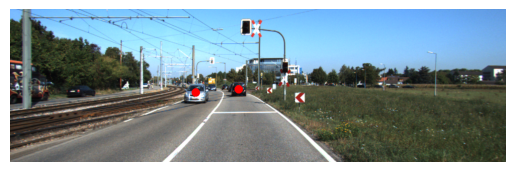

In [4]:
# Edit the following line to view a different scene
test_image_dir = "dataset/testing/image_02/0002"
test_image_dir_list = os.listdir(test_image_dir)
test_image_dir_list.sort()
test_image = Image.open(os.path.join(test_image_dir, test_image_dir_list[0]))
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Resize((384, 1248))])
image = transform(test_image).to(device)
boxes, labels = predict(image, model)
if len(labels) > 0:
    centers = get_centers(boxes)
    centers_np = centers.cpu().numpy()
    first_image = image_with_center_coordinates(image, centers_np)
else:
    first_image = to_pil_image(image)
plt.imshow(first_image)
plt.axis("off")
plt.show()

# Filter Tracking

In [ ]:
test_filters = ["kalman", "particle"]

for filter_type in test_filters:
    # Use larger standard deviations for faster moving objects.
    filter_params = get_filter_params(filter_type=filter_type, dt=0.1,
                                      sigma_ax=20, sigma_ay=5,
                                      num_particles=1000, pos_std=20,
                                      process_std_x=50,
                                      process_std_y=20,
                                      obs_std=50)
    
    # Create first filters
    filterList = {}
    for i in range(len(labels)):
        add_filter_dict(filterList, i, filter_type, centers[i], **filter_params)

    # For fast moving objects, allow low misses (to avoid spurious filters)
    # and high threshold (to capture distant detections).
    run_filter_loop(images_dir=test_image_dir,
                    image_name_list=test_image_dir_list[1:],
                    model=model, filterList=filterList,
                    allowed_misses=3, threshold=400,
                    first_image=first_image,
                    filter_type=filter_type,
                    **filter_params)